In [19]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.prepared import prep
import os
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.ops import unary_union


In [20]:
base_dir = 'D:/Desktop/MSc Thesis - Copy/'
output_csv = 'D:/Desktop/MSc Thesis - Copy/shapefiles/_network_parts_3/node_urban_features.csv'
nodes_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_3/nodes.csv'), header = 0)

# loading building and node data
gdf_buildings = gpd.read_file(os.path.join(base_dir, 'Data/GIS data/Building footprints/footprint_shapefile/Z_F_merge/merge_valid.shp'), crs='EPSG:5174')

gdf_nodes = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df['node_x'], nodes_df['node_y']), crs='EPSG:5174')
#gdf_nodes = gdf_nodes.to_crs(gdf_buildings.crs)

d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [21]:
# before = len(gdf_buildings)
# gdf_buildings = gdf_buildings.drop_duplicates(subset='geometry')
# after = len(gdf_buildings)

# print(f"Dropped {before - after} duplicate geometries (exact matches).")

In [22]:
# sindex = gdf_buildings.sindex

# cleaned_geometries = []
# clipped_count = 0

# for i, geom in enumerate(gdf_buildings.geometry):
#     # Use spatial index to get potential overlaps
#     possible_matches_index = list(sindex.intersection(geom.bounds))
#     possible_matches_index.remove(i)  # remove self

#     overlapping = gdf_buildings.iloc[possible_matches_index]
#     overlapping = overlapping[overlapping.geometry.intersects(geom)]

#     if not overlapping.empty:
#         # Union of all intersecting geometries
#         intersection_union = unary_union(overlapping.geometry)
#         clipped_geom = geom.difference(intersection_union)

#         if not clipped_geom.equals(geom):
#             clipped_count += 1

#         cleaned_geometries.append(clipped_geom)
#     else:
#         cleaned_geometries.append(geom)

# gdf_buildings['geometry'] = cleaned_geometries

# print(f"{clipped_count} building geometries were clipped to remove overlaps.")

In [23]:
# loading and filtering green areas
from shapely.geometry import MultiPolygon

gdf_green = gpd.read_file(os.path.join(base_dir, 'Data/GIS data/Green/green/green_clipped.shp'))
gdf_green.to_crs(gdf_buildings.crs, inplace=True)

green_types = ['allotments', 'cemetery', 'farmland', 'farmyard', 'forest', 'grass', 'heath', 'meadow',
               'nature_reserve', 'orchard', 'park', 'scrub', 'vineyard'] # only these types are considered green areas
gdf_green = gdf_green[gdf_green['fclass'].isin(green_types)]

gdf_green = gdf_green.explode(index_parts=False).reset_index(drop=True)

merged_geoms = unary_union(gdf_green.geometry)

if isinstance(merged_geoms, MultiPolygon):
    merged_geoms = list(merged_geoms.geoms)
else:
    merged_geoms = [merged_geoms]

gdf_green = gpd.GeoDataFrame(geometry=merged_geoms, crs=gdf_green.crs)


# clipping green areas that overlap with buildings
sindex = gdf_buildings.sindex

def clip_with_local_buildings(green_geom):
    possible_matches_index = list(sindex.intersection(green_geom.bounds))
    local_buildings = gdf_buildings.iloc[possible_matches_index]
    overlaps = local_buildings[local_buildings.intersects(green_geom)]

    if not overlaps.empty:
        buildings_union = unary_union(overlaps.geometry)
        return green_geom.difference(buildings_union)
    else:
        return green_geom

gdf_green['geometry'] = gdf_green.geometry.apply(clip_with_local_buildings)

# removing green areas that are now empty (fully covered by buildings)
gdf_green = gdf_green[~gdf_green.geometry.is_empty]


#gdf_green = gdf_green.dissolve().reset_index(drop=True)  # merging overlapping green shapes

In [24]:
# ensuring required attributes exist and are float
gdf_buildings['footprint'] = gdf_buildings['footprint'].astype(float)
gdf_buildings['gfa'] = gdf_buildings['gfa'].astype(float)

In [25]:
buffer_radius = 100  # meters
buffer_area = np.pi * buffer_radius ** 2

In [26]:
print("CRS of buildings:", gdf_buildings.crs)
print("CRS of nodes:", gdf_nodes.crs)
print(gdf_buildings.is_valid.value_counts())

CRS of buildings: EPSG:5174
CRS of nodes: EPSG:5174
True    597234
Name: count, dtype: int64


In [27]:
import matplotlib.pyplot as plt

# making sure that the CRS of the nodes and buildings are the same

fig2, ax2 = plt.subplots(figsize=(8, 8))
gdf_buildings.plot(ax=ax2, color='grey', alpha=0.3)
gdf_nodes.plot(ax=ax2, color='red', markersize=3)
ax2.set_title('All nodes and building footprints')
ax2.set_axis_off()
plt.tight_layout()
plt.show()

In [28]:
# feature calculations

def calc_GSI(intersected, buffer_area):
    '''
    GSI (Ground Space Index) = Footprint / Area of the buffer 
    '''
    footprint_weighted = (intersected['footprint'] * (intersected['area_overlap'] / intersected.geometry.area)).sum()
    gsi = footprint_weighted / buffer_area if buffer_area > 0 else np.nan
    return np.clip(gsi, 0, 1) if not np.isnan(gsi) else np.nan
    # return footprint_weighted / buffer_area if buffer_area > 0 else np.nan



def calc_FSI(intersected, buffer_area):
    '''
    FSI (Floor Space Index) = GFA / Area of the buffer 
    '''
    gfa_weighted = (intersected['gfa'] * (intersected['area_overlap'] / intersected.geometry.area)).sum()
    return gfa_weighted / buffer_area if buffer_area > 0 else np.nan


def calc_OSR(FSI, GSI):
    '''
    OSR (Open Space Ratio) = (1 - GSI) / FSI
    '''
    return (1 - GSI) / FSI if FSI > 0 else np.nan


def calc_ABH(intersected):
    '''
    ABH (Average Building Height) = Average of building heights
    '''
    return intersected['height_1'].mean()


def calc_WMHB(intersected):
    '''
    WMHB (Area-Weighted Mean Building Height) = Sum of (height * footprint) / Sum of footprint
    '''
    heights = intersected['height_1']
    weights = intersected['area_overlap']
    return np.average(heights, weights=weights) if weights.sum() > 0 else np.nan


def calc_HSTD(intersected):
    '''
    HSTD (Standard Deviation of Building Height)
    '''
    return intersected['height_1'].std()

def calc_GrCR(green_overlap_area, area_buffer):
    '''
    GrCR (Green Coverage Ratio) = Green Area / Area of the buffer
    '''
    grcr = green_overlap_area / area_buffer if area_buffer > 0 else np.nan
    return np.clip(grcr, 0, 1) if not np.isnan(grcr) else np.nan
    #return green_overlap_area / area_buffer if area_buffer > 0 else np.nan


def calc_GD(point, green_gdf, green_sindex):
    '''
    GD (Green Distance): distance from the node to the nearest green polygon.
    If the point is inside a green polygon, distance is 0.
    '''
    if green_gdf.contains(point).any():
        return 0.0
    return green_gdf.distance(point).min()

In [29]:
# initializing result columns
gdf_nodes['FSI'] = np.nan
gdf_nodes['GSI'] = np.nan
gdf_nodes['OSR'] = np.nan
gdf_nodes['ABH'] = np.nan
gdf_nodes['WMHB'] = np.nan
gdf_nodes['HSTD'] = np.nan
gdf_nodes['GrCR'] = np.nan

Processing node 168...


C:\Users\Michele\AppData\Local\Temp\ipykernel_10784\218209985.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


168 - 1 of 8: 3.360000251933423, 0.5302072775840363, 0.13981925214012528, 8.402298850574713, 34.373978447343546, 8.655499354308828, 0.0, 166.1789961286918
Processing node 836...
836 - 2 of 8: 0.9753259002203678, 0.07051264069267775, 0.9530018213371667, 48.333333333333336, 45.32451226705699, 5.750362307426087, 0.38562178694258564, 13.751337501932378
Processing node 76...
76 - 3 of 8: 1.0014204506592288, 0.2594280809220399, 0.7395214653250253, 12.352941176470589, 15.142032343597592, 23.291471552025726, 0.15588511827245274, 41.696095634918386
Processing node 70...


C:\Users\Michele\AppData\Local\Temp\ipykernel_10784\218209985.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


70 - 4 of 8: 1.5005061541729032, 0.3880106924184923, 0.40785524663099, 9.241379310344827, 11.342356364520711, 7.0113208947854595, 0.0, 232.62388523557354
Processing node 88...


C:\Users\Michele\AppData\Local\Temp\ipykernel_10784\218209985.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


88 - 5 of 8: 1.1524070767575956, 0.350879902644586, 0.563273265538922, 10.957142857142857, 8.457568369232279, 5.486308952412819, 0.0, 163.56663029030244
Processing node 657...
657 - 6 of 8: 0.5483317190170518, 0.2074623227993575, 1.4453617212248058, 7.45945945945946, 8.41085273322859, 6.867013047676849, 0.23698864511514164, 47.70106847106525
Processing node 896...


C:\Users\Michele\AppData\Local\Temp\ipykernel_10784\218209985.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


896 - 7 of 8: 1.0404371710197373, 0.3273768750145231, 0.6464812520358493, 6.8120805369127515, 9.719728461349515, 6.201971272841051, 0.0, 189.76849756918278
Processing node 841...


C:\Users\Michele\AppData\Local\Temp\ipykernel_10784\218209985.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


841 - 8 of 8: 1.3114934549323145, 0.34219549949737355, 0.5015690303514138, 10.8, 10.543650817477063, 7.235633072849415, 0.0, 217.5452175479751


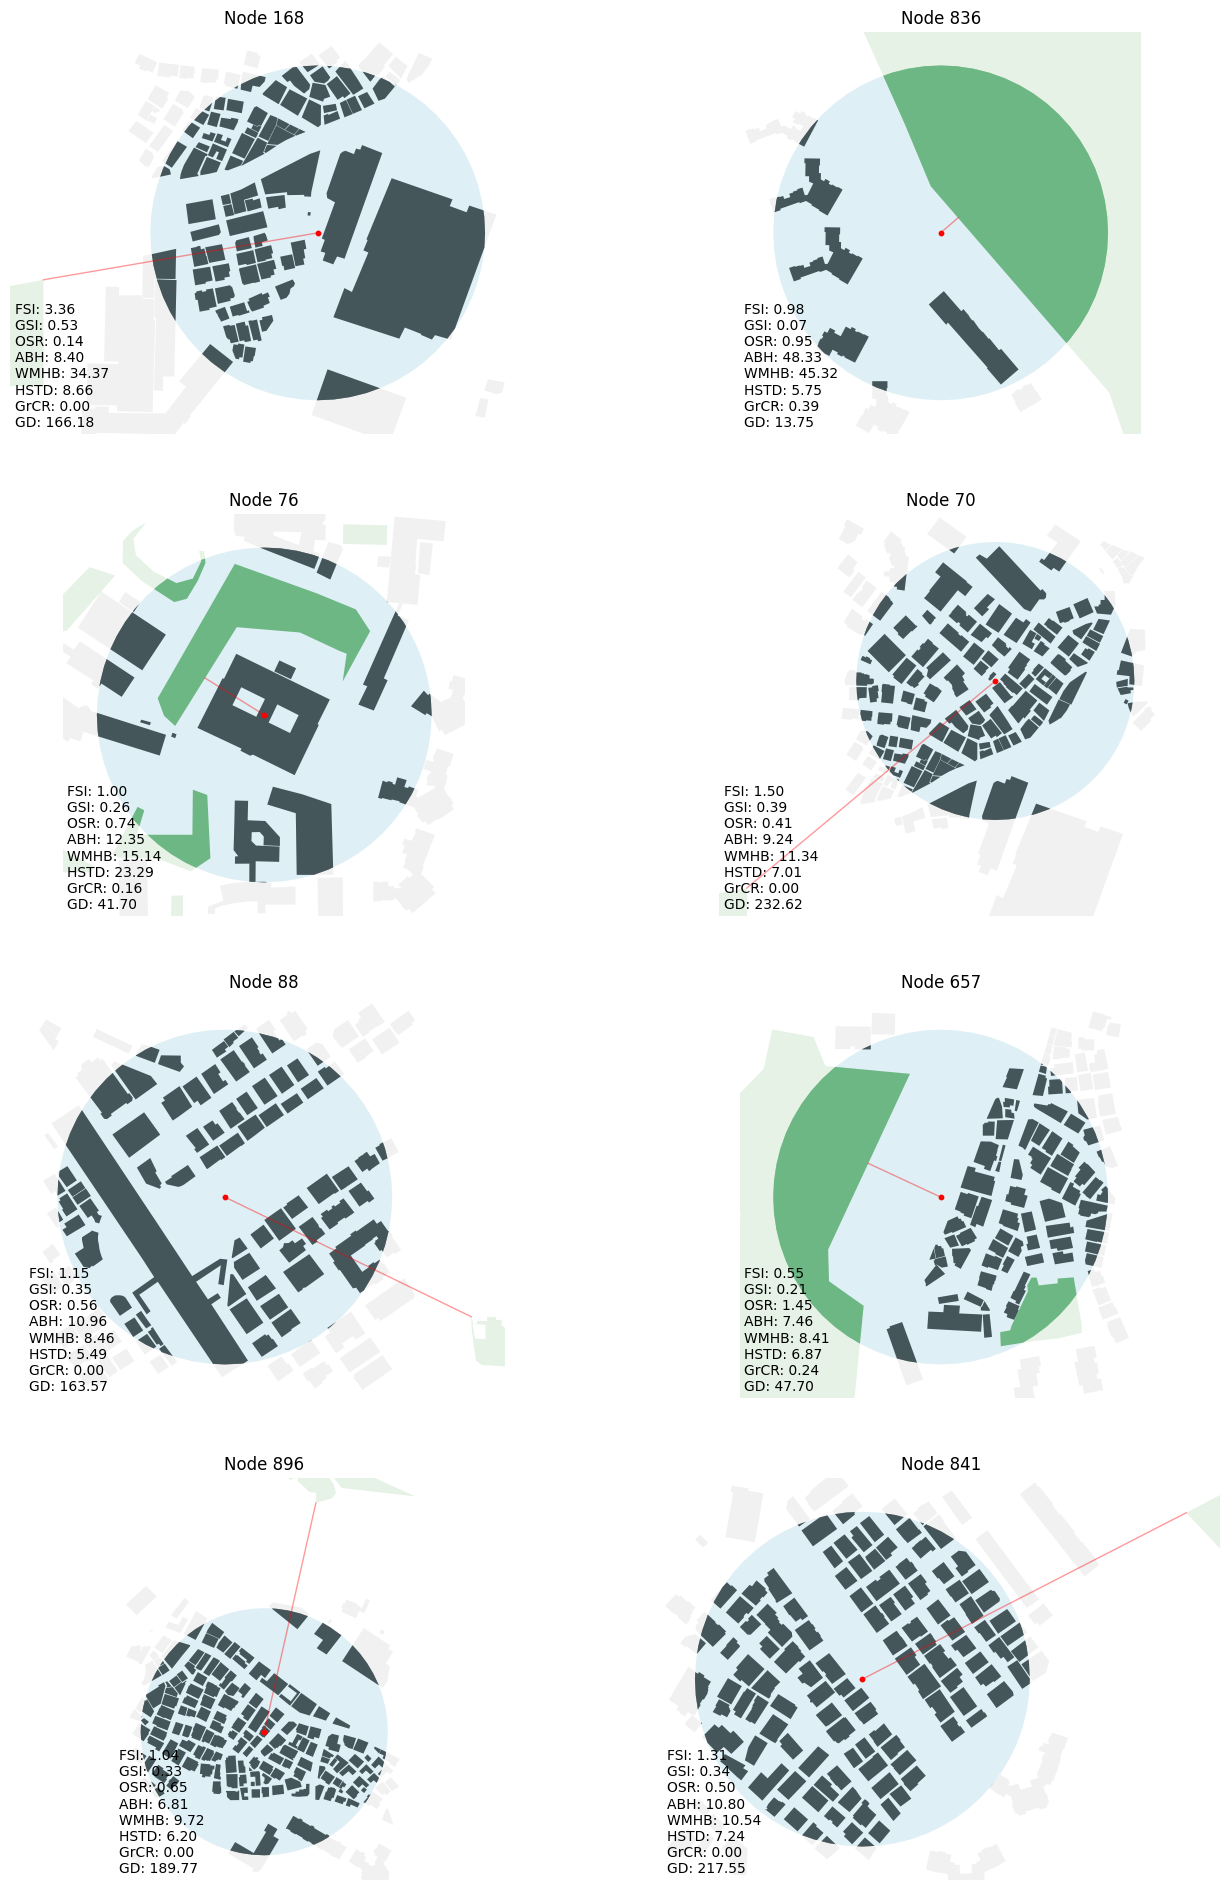

In [30]:
from shapely.ops import nearest_points

# selecting 8 random nodes
sampled_nodes = gdf_nodes.sample(n=8, random_state=42)

# building spatial index
buildings_sindex = gdf_buildings.sindex
green_sindex = gdf_green.sindex

# creating plots
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten()

for idx, (node_idx, node) in enumerate(sampled_nodes.iterrows()):
        print(f'Processing node {node_idx}...')
        ax = axes[idx]
        buffer_geom = node.geometry.buffer(buffer_radius)

        possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
        buildings_candidates = gdf_buildings.iloc[possible_idx]
        buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

        # if buildings_in_buffer.empty:
        #         continue

        buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area
        
        #print(buildings_in_buffer[['area_overlap']].describe())

        # if buildings_in_buffer['area_overlap'].sum() == 0:
        #         continue

        possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
        green_candidates = gdf_green.iloc[possible_green_idx]
        green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

        green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
        fsi = calc_FSI(buildings_in_buffer, buffer_area)
        gsi = calc_GSI(buildings_in_buffer, buffer_area)
        osr = calc_OSR(fsi, gsi)
        abh = calc_ABH(buildings_in_buffer)
        wmhb = calc_WMHB(buildings_in_buffer)
        hstd = calc_HSTD(buildings_in_buffer)
        grcr = calc_GrCR(green_overlap_area, buffer_area)
        gd = calc_GD(node.geometry, gdf_green, green_sindex)

        gdf_nodes.at[idx, 'FSI'] = fsi
        gdf_nodes.at[idx, 'GSI'] = gsi
        gdf_nodes.at[idx, 'OSR'] = osr
        gdf_nodes.at[idx, 'ABH'] = abh
        gdf_nodes.at[idx, 'WMHB'] = wmhb
        gdf_nodes.at[idx, 'HSTD'] = hstd
        gdf_nodes.at[idx, 'GrCR'] = grcr


        # plotting elements
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geom], crs=gdf_nodes.crs)
        node_center = gpd.GeoDataFrame(geometry=[node.geometry], crs=gdf_nodes.crs)

        # background elemetns
        buildings_candidates.plot(ax=ax, color='lightgrey', alpha=0.3)
        #green_candidates.plot(ax=ax, color='green', alpha=0.1)
        gdf_green.plot(ax=ax, color='green', alpha=0.1)

        # buildings and green areas in buffer
        buildings_in_buffer_intersection = buildings_in_buffer.intersection(buffer_geom)
        buildings_in_buffer_intersection.plot(ax=ax, color='black')

        green_in_buffer_intersection = green_in_buffer.intersection(buffer_geom)
        green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)
        
        # buffer and node center
        buffer_gdf.plot(ax=ax, facecolor='lightblue', alpha=0.4)
        node_center.plot(ax=ax, color='red', markersize=10, alpha=1)

        # nearest green area line
        distances = gdf_green.distance(node.geometry)
        min_idx = distances.idxmin()
        nearest_geom = gdf_green.loc[min_idx].geometry

        from shapely.ops import nearest_points
        nearest_point_on_green = nearest_points(node.geometry, nearest_geom)[1]

        ax.plot(
            [node.geometry.x, nearest_point_on_green.x],
            [node.geometry.y, nearest_point_on_green.y],
            color='red', linewidth=1, alpha=0.4
        )

        # setting axis limits slightly outside buffer
        # get bounds of buffer
        xmin, ymin, xmax, ymax = buffer_geom.bounds

        # include green line endpoints
        x_vals = [node.geometry.x, nearest_point_on_green.x]
        y_vals = [node.geometry.y, nearest_point_on_green.y]

        xmin = min(xmin, min(x_vals))
        xmax = max(xmax, max(x_vals))
        ymin = min(ymin, min(y_vals))
        ymax = max(ymax, max(y_vals))

        # add some padding
        padding = buffer_radius * 0.2  # 20% extra
        ax.set_xlim(xmin - padding, xmax + padding)
        ax.set_ylim(ymin - padding, ymax + padding)

        ax.set_title(f'Node {node_idx}')
        ax.set_axis_off()
        ax.text(0.01, 0.01,
            f'FSI: {fsi:.2f}\nGSI: {gsi:.2f}\nOSR: {osr:.2f}\nABH: {abh:.2f}\nWMHB: {wmhb:.2f}\nHSTD: {hstd:.2f}\nGrCR: {grcr:.2f}\nGD: {gd:.2f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
    
        print(f'{node_idx} - {idx+1} of 8: {fsi}, {gsi}, {osr}, {abh}, {wmhb}, {hstd}, {grcr}, {gd}')


# for idx, (node_idx, node) in enumerate(sampled_nodes.iterrows()):
#     ax = axes[idx]
#     buffer_geom = node.geometry.buffer(buffer_radius)
#     buffer_area = np.pi * buffer_radius ** 2

#     # getting building intersections
#     possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
#     buildings_candidates = gdf_buildings.iloc[possible_idx]
#     buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()
#     buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area

#     fsi = calc_FSI(buildings_in_buffer, buffer_area)
#     gsi = calc_GSI(buildings_in_buffer, buffer_area)
#     osr = calc_OSR(fsi, gsi)
#     abh = calc_ABH(buildings_in_buffer)
#     wmhb = calc_WMHB(buildings_in_buffer)
#     hstd = calc_HSTD(buildings_in_buffer)

#     # getting green area intersections
#     green_idx = list(green_sindex.intersection(buffer_geom.bounds))
#     green_candidates = gdf_green.iloc[green_idx]
#     green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()
#     green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
#     grcr = calc_GrCR(green_overlap_area, buffer_area)

#     # plotting elements
#     gdf_buildings.plot(ax=ax, color='lightgrey', alpha=0.3)
#     buildings_in_buffer.plot(ax=ax, color='black')
#     gdf_green.plot(ax=ax, color='green', alpha=0.2)
#     green_in_buffer.plot(ax=ax, color='green', alpha=0.8)
#     gpd.GeoDataFrame(geometry=[buffer_geom], crs=gdf_nodes.crs).plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

#     ax.set_title(f'Node {node_idx}')
#     ax.set_axis_off()
#     ax.text(0.01, 0.01,
#             f'FSI: {fsi:.2f}\nGSI: {gsi:.2f}\nOSR: {osr:.2f}\nABH: {abh:.2f}\nWMHB: {wmhb:.2f}\nHSTD: {hstd:.2f}\nGrCR: {grcr:.2f}',
#             transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
# #     print(f'{node_idx}/8 - FSI: {fsi:.2f}, GSI: {gsi:.2f}, OSR: {osr:.2f}, ABH: {abh:.2f}, WMHB: {wmhb:.2f}, HSTD: {hstd:.2f}, GrCR: {grcr:.2f}')

Processing node 101...
101 - 1 of 8: 1.1295821187440935, 0.1959912661550329, 0.7117753729484407, 14.210526315789474, 22.315976790436547, 14.665933858153092, 0.11262214003805716, 29.263907863022393
Processing node 251...


C:\Users\Michele\AppData\Local\Temp\ipykernel_10784\4104154833.py:71: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


251 - 2 of 8: 1.161694385302424, 0.2892571602609195, 0.6118156795206106, 10.523809523809524, 11.592325238721992, 4.674182853503417, 0.0, 204.21389511787407
Processing node 333...


C:\Users\Michele\AppData\Local\Temp\ipykernel_10784\4104154833.py:71: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


333 - 3 of 8: 0.601727836825752, 0.17478575607056732, 1.3714077917395695, 9.96078431372549, 10.429410088544307, 4.103465775725322, 0.0, 259.48798084279656
Processing node 745...
745 - 4 of 8: 0.731370938665256, 0.13615855541359512, 1.1811262916228338, 15.392857142857142, 17.13122822193888, 9.150346221801444, 0.26061047365869694, 26.010397866923498


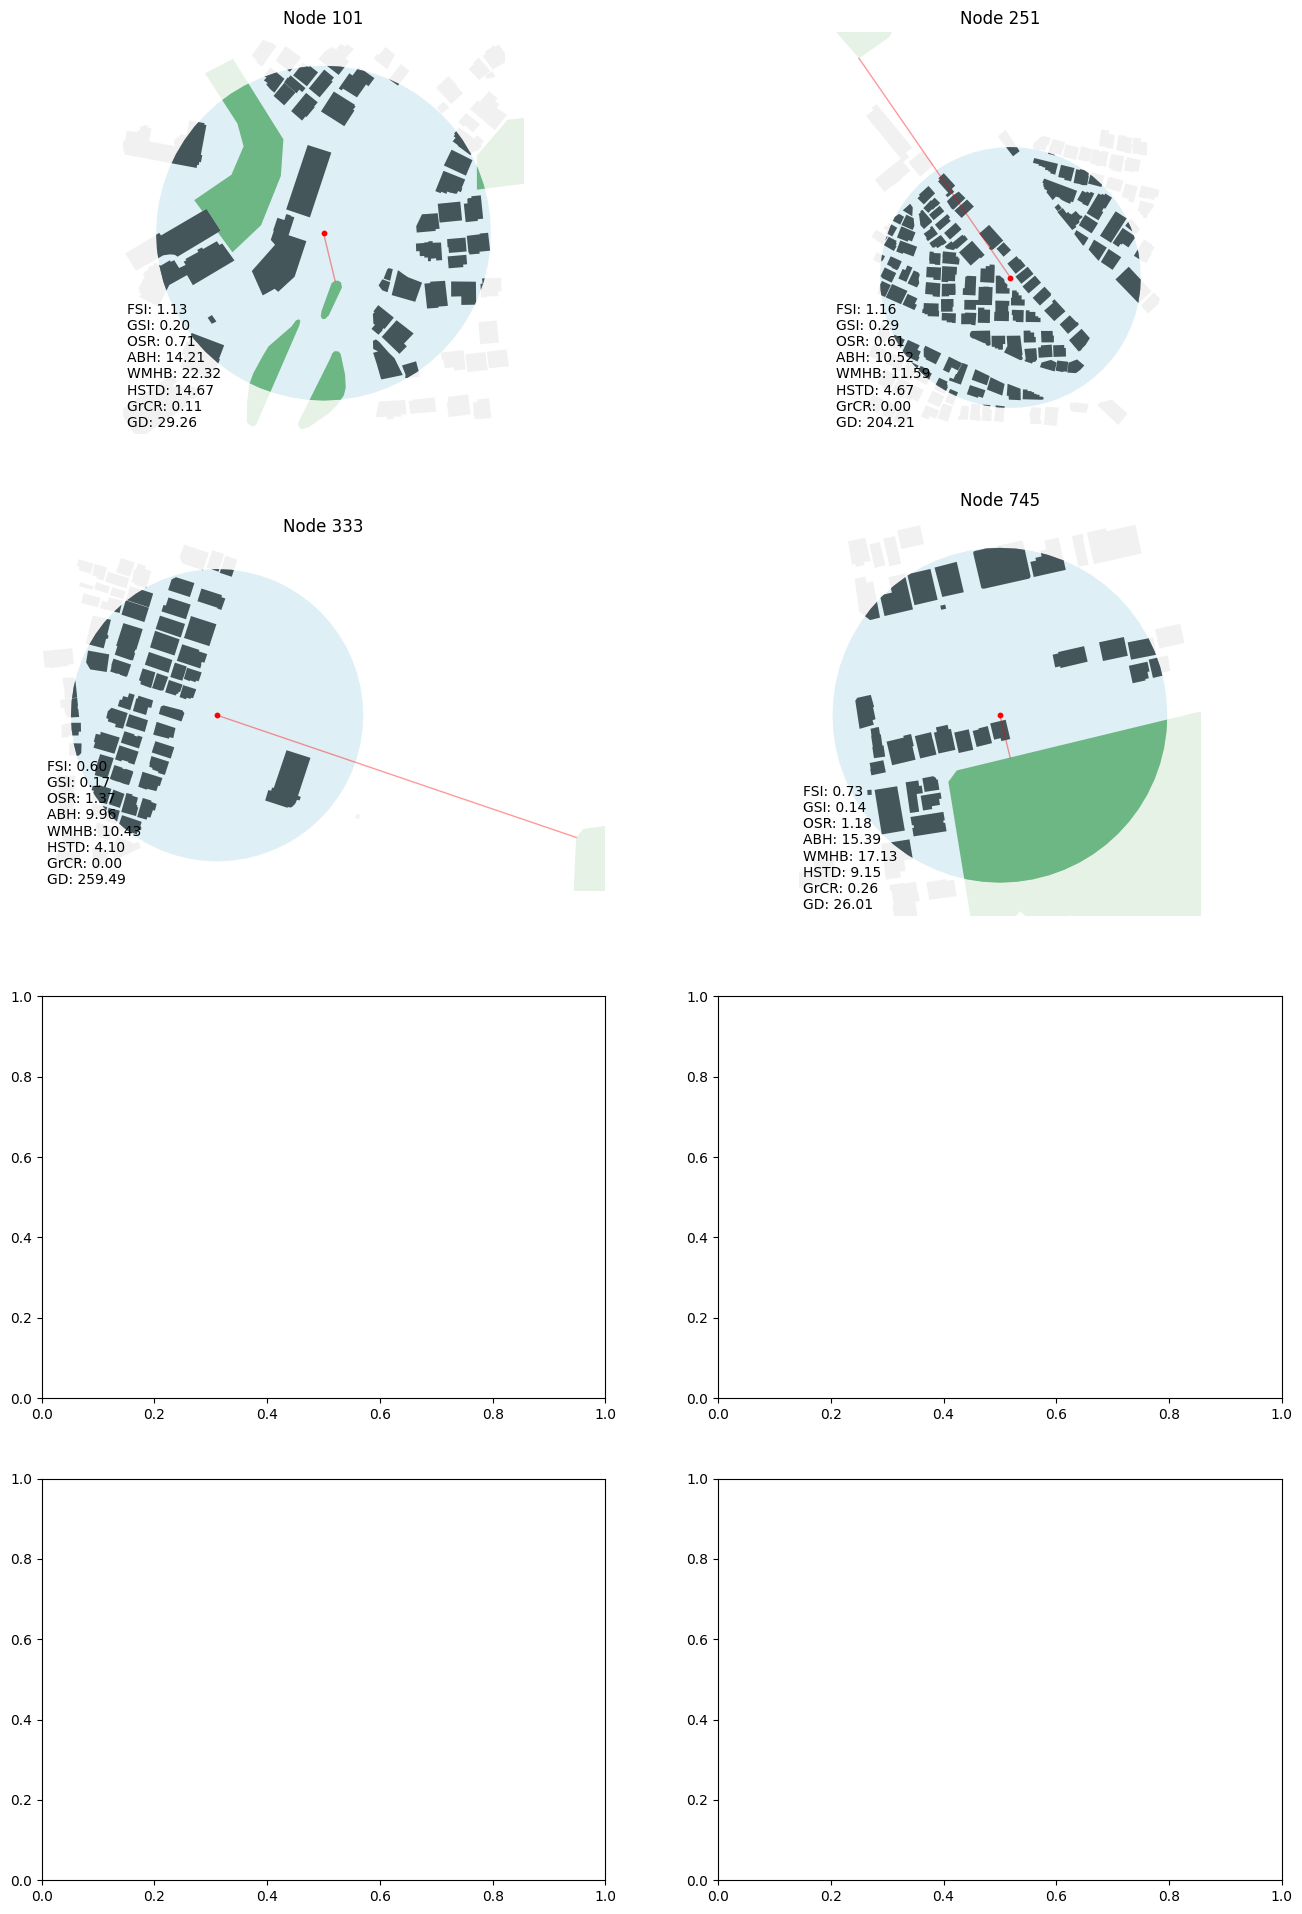

In [31]:
from shapely.ops import nearest_points
# errors in GSI
# selecting nodes with id 1, 6, ,9 and 14
ids = [3328, 600, 1335, 997, 390, 409, 517]
sampled_nodes = gdf_nodes[gdf_nodes['node_id'].isin(ids)].copy()

# building spatial index
buildings_sindex = gdf_buildings.sindex
green_sindex = gdf_green.sindex

# creating plots
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten()

for idx, (node_idx, node) in enumerate(sampled_nodes.iterrows()):
        print(f'Processing node {node_idx}...')
        ax = axes[idx]
        buffer_geom = node.geometry.buffer(buffer_radius)

        possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
        buildings_candidates = gdf_buildings.iloc[possible_idx]
        buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

        # if buildings_in_buffer.empty:
        #         continue

        buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area
        
        #print(buildings_in_buffer[['area_overlap']].describe())

        # if buildings_in_buffer['area_overlap'].sum() == 0:
        #         continue

        possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
        green_candidates = gdf_green.iloc[possible_green_idx]
        green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

        green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
        fsi = calc_FSI(buildings_in_buffer, buffer_area)
        gsi = calc_GSI(buildings_in_buffer, buffer_area)
        osr = calc_OSR(fsi, gsi)
        abh = calc_ABH(buildings_in_buffer)
        wmhb = calc_WMHB(buildings_in_buffer)
        hstd = calc_HSTD(buildings_in_buffer)
        grcr = calc_GrCR(green_overlap_area, buffer_area)
        gd = calc_GD(node.geometry, gdf_green, green_sindex)

        gdf_nodes.at[idx, 'FSI'] = fsi
        gdf_nodes.at[idx, 'GSI'] = gsi
        gdf_nodes.at[idx, 'OSR'] = osr
        gdf_nodes.at[idx, 'ABH'] = abh
        gdf_nodes.at[idx, 'WMHB'] = wmhb
        gdf_nodes.at[idx, 'HSTD'] = hstd
        gdf_nodes.at[idx, 'GrCR'] = grcr


        # plotting elements
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geom], crs=gdf_nodes.crs)
        node_center = gpd.GeoDataFrame(geometry=[node.geometry], crs=gdf_nodes.crs)

        # background elemetns
        buildings_candidates.plot(ax=ax, color='lightgrey', alpha=0.3)
        #green_candidates.plot(ax=ax, color='green', alpha=0.1)
        gdf_green.plot(ax=ax, color='green', alpha=0.1)

        # buildings and green areas in buffer
        buildings_in_buffer_intersection = buildings_in_buffer.intersection(buffer_geom)
        buildings_in_buffer_intersection.plot(ax=ax, color='black')

        green_in_buffer_intersection = green_in_buffer.intersection(buffer_geom)
        green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)
        
        # buffer and node center
        buffer_gdf.plot(ax=ax, facecolor='lightblue', alpha=0.4)
        node_center.plot(ax=ax, color='red', markersize=10, alpha=1)

        # nearest green area line
        distances = gdf_green.distance(node.geometry)
        min_idx = distances.idxmin()
        nearest_geom = gdf_green.loc[min_idx].geometry

        from shapely.ops import nearest_points
        nearest_point_on_green = nearest_points(node.geometry, nearest_geom)[1]

        ax.plot(
            [node.geometry.x, nearest_point_on_green.x],
            [node.geometry.y, nearest_point_on_green.y],
            color='red', linewidth=1, alpha=0.4
        )

        # setting axis limits slightly outside buffer
        # get bounds of buffer
        xmin, ymin, xmax, ymax = buffer_geom.bounds

        # include green line endpoints
        x_vals = [node.geometry.x, nearest_point_on_green.x]
        y_vals = [node.geometry.y, nearest_point_on_green.y]

        xmin = min(xmin, min(x_vals))
        xmax = max(xmax, max(x_vals))
        ymin = min(ymin, min(y_vals))
        ymax = max(ymax, max(y_vals))

        # add some padding
        padding = buffer_radius * 0.2  # 20% extra
        ax.set_xlim(xmin - padding, xmax + padding)
        ax.set_ylim(ymin - padding, ymax + padding)

        ax.set_title(f'Node {node_idx}')
        ax.set_axis_off()
        ax.text(0.01, 0.01,
            f'FSI: {fsi:.2f}\nGSI: {gsi:.2f}\nOSR: {osr:.2f}\nABH: {abh:.2f}\nWMHB: {wmhb:.2f}\nHSTD: {hstd:.2f}\nGrCR: {grcr:.2f}\nGD: {gd:.2f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
    
        print(f'{node_idx} - {idx+1} of 8: {fsi}, {gsi}, {osr}, {abh}, {wmhb}, {hstd}, {grcr}, {gd}')

In [32]:
# iterating through each node and calculating the urban features

for idx, (node_idx, node) in enumerate(gdf_nodes.iterrows()):
        buffer_geom = node.geometry.buffer(buffer_radius)

        possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
        buildings_candidates = gdf_buildings.iloc[possible_idx]
        buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

        buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area

        possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
        green_candidates = gdf_green.iloc[possible_green_idx]
        green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

        green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
        fsi = calc_FSI(buildings_in_buffer, buffer_area)
        gsi = calc_GSI(buildings_in_buffer, buffer_area)
        osr = calc_OSR(fsi, gsi)
        abh = calc_ABH(buildings_in_buffer)
        wmhb = calc_WMHB(buildings_in_buffer)
        hstd = calc_HSTD(buildings_in_buffer)
        grcr = calc_GrCR(green_overlap_area, buffer_area)
        gd = calc_GD(node.geometry, gdf_green, green_sindex)

        gdf_nodes.at[idx, 'FSI'] = fsi
        gdf_nodes.at[idx, 'GSI'] = gsi
        gdf_nodes.at[idx, 'OSR'] = osr
        gdf_nodes.at[idx, 'ABH'] = abh
        gdf_nodes.at[idx, 'WMHB'] = wmhb
        gdf_nodes.at[idx, 'HSTD'] = hstd
        gdf_nodes.at[idx, 'GrCR'] = grcr
        gdf_nodes.at[idx, 'GD'] = gd
        
        print(f'{idx+1} of {len(gdf_nodes)} | FSI: {fsi:.2f}, GSI: {gsi:.2f}, OSR: {osr:.2f}, ABH: {abh:.2f}, WMHB: {wmhb:.2f}, HSTD: {hstd:.2f}, GrCR: {grcr:.2f}, GD: {gd:.2f}')


1 of 971 | FSI: 0.40, GSI: 0.11, OSR: 2.20, ABH: 9.25, WMHB: 15.92, HSTD: 13.84, GrCR: 0.14, GD: 50.78
2 of 971 | FSI: 2.03, GSI: 0.37, OSR: 0.31, ABH: 6.71, WMHB: 8.75, HSTD: 13.78, GrCR: 0.14, GD: 43.99
3 of 971 | FSI: 1.03, GSI: 0.26, OSR: 0.72, ABH: 7.15, WMHB: 5.27, HSTD: 5.10, GrCR: 0.12, GD: 5.66
4 of 971 | FSI: 1.86, GSI: 0.38, OSR: 0.33, ABH: 7.34, WMHB: 6.42, HSTD: 7.48, GrCR: 0.12, GD: 7.98
5 of 971 | FSI: 2.19, GSI: 0.43, OSR: 0.26, ABH: 7.90, WMHB: 7.79, HSTD: 7.95, GrCR: 0.13, GD: 0.00
6 of 971 | FSI: 2.03, GSI: 0.33, OSR: 0.33, ABH: 11.05, WMHB: 19.69, HSTD: 16.26, GrCR: 0.22, GD: 52.71
7 of 971 | FSI: 1.35, GSI: 0.42, OSR: 0.43, ABH: 6.21, WMHB: 9.91, HSTD: 5.87, GrCR: 0.00, GD: 93.34
8 of 971 | FSI: 1.59, GSI: 0.40, OSR: 0.38, ABH: 8.49, WMHB: 13.60, HSTD: 7.48, GrCR: 0.00, GD: 136.78
9 of 971 | FSI: 1.96, GSI: 0.36, OSR: 0.33, ABH: 8.00, WMHB: 7.01, HSTD: 12.40, GrCR: 0.13, GD: 46.91
10 of 971 | FSI: 1.78, GSI: 0.33, OSR: 0.38, ABH: 5.78, WMHB: 5.19, HSTD: 13.30, GrCR

In [33]:
# set the parameters of cardinal nodes to NaN

for i in range(8):
    gdf_nodes.at[i, 'FSI'] = np.nan
    gdf_nodes.at[i, 'GSI'] = np.nan
    gdf_nodes.at[i, 'OSR'] = np.nan
    gdf_nodes.at[i, 'ABH'] = np.nan
    gdf_nodes.at[i, 'WMHB'] = np.nan
    gdf_nodes.at[i, 'HSTD'] = np.nan
    gdf_nodes.at[i, 'GrCR'] = np.nan
    gdf_nodes.at[i, 'GD'] = np.nan


In [34]:
parameters = ['FSI', 'GSI', 'OSR', 'ABH', 'WMHB', 'HSTD', 'GrCR', 'GD']

n_params = len(parameters)
n_cols = 3
n_rows = (n_params + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, param in enumerate(parameters):
    ax = axes[i]
    data = gdf_nodes[param]

    # clipping color range to 1st–99th percentile to reduce outlier impact
    vmin = data.quantile(0.01)
    vmax = data.quantile(0.99)

    gdf_nodes.plot(
        ax=ax,
        column=param,
        cmap='viridis',
        legend=True,
        markersize=5,
        alpha=0.6,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={'shrink': 0.5, 'label': ''}
    )

    ax.set_title(f'{param}', fontsize=10)
    ax.set_axis_off()

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [35]:
for i in range(8):
    gdf_nodes.at[i, 'FSI'] = np.nan
    gdf_nodes.at[i, 'GSI'] = np.nan
    gdf_nodes.at[i, 'OSR'] = np.nan
    gdf_nodes.at[i, 'ABH'] = np.nan
    gdf_nodes.at[i, 'WMHB'] = np.nan
    gdf_nodes.at[i, 'HSTD'] = np.nan
    gdf_nodes.at[i, 'GrCR'] = np.nan
    gdf_nodes.at[i, 'GD'] = np.nan

In [36]:
#exporting nodes with urban features to csv

gdf_nodes.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_3/nodes_urban_feat.csv"))

In [ ]:

# buildings_sindex = gdf_buildings.sindex
# green_sindex = gdf_green.sindex

# for idx, node in gdf_nodes.iterrows():
#     buffer_geom = node.geometry.buffer(buffer_radius)

#     possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
#     buildings_candidates = gdf_buildings.iloc[possible_idx]
#     buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

#     if buildings_in_buffer.empty:
#         continue

#     buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area
        
#     #print(buildings_in_buffer[['area_overlap']].describe())

#     if buildings_in_buffer['area_overlap'].sum() == 0:
#         continue

#     fsi = calc_FSI(buildings_in_buffer, buffer_area)
#     gsi = calc_GSI(buildings_in_buffer, buffer_area)
#     osr = calc_OSR(fsi, gsi)
#     abh = calc_ABH(buildings_in_buffer)
#     wmhb = calc_WMHB(buildings_in_buffer)
#     hstd = calc_HSTD(buildings_in_buffer)

#     possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
#     green_candidates = gdf_green.iloc[possible_green_idx]
#     green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

#     green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
#     grcr = calc_GrCR(green_overlap_area, buffer_area)

#     gdf_nodes.at[idx, 'FSI'] = fsi
#     gdf_nodes.at[idx, 'GSI'] = gsi
#     gdf_nodes.at[idx, 'OSR'] = osr
#     gdf_nodes.at[idx, 'ABH'] = abh
#     gdf_nodes.at[idx, 'WMHB'] = wmhb
#     gdf_nodes.at[idx, 'HSTD'] = hstd
#     gdf_nodes.at[idx, 'GrCR'] = grcr
#     print(f'{idx}/{len(gdf_nodes)}: {fsi}, {gsi}, {osr}, {abh}, {wmhb}, {hstd}, {grcr}')


8/3774: 1.5839822259282088, 0.42654306666393427, 0.3620349546536242, 9.0, 970.1786118310049, 5.510050429688, 0.001668729616322349
9/3774: 1.376143281976183, 0.31227911435629097, 0.49974511713353076, 10.5, 795.509105342711, 5.255815398738618, 0.22746839609904668
10/3774: 0.5339830105979907, 0.0864127619337188, 1.710891957111489, 22.666666666666668, 47.465579412100816, 27.31910198621714, 0.5533992331756967
11/3774: 1.7343977130046622, 0.4238708052231626, 0.33217824865483364, 11.991735537190083, 1205.0162656596817, 2.8852956745326095, 0.0
12/3774: 0.41207380772543345, 0.07401666513553766, 2.2471298041865575, 16.733333333333334, 191.3941292716046, 13.30663994653296, 0.23524489968609236
13/3774: 0.4556349607798067, 0.13198087077390155, 1.9050757820262687, 9.24390243902439, 323.34124301285465, 4.035966351475679, 0.0
14/3774: 6.55117115662769, 0.3464363552244926, 0.09976287127139244, 51.333333333333336, 264.0505418109983, 49.57883223776661, 0.0
15/3774: 1.1268304055797973, 0.3684186323039119,

KeyboardInterrupt: 

In [ ]:
output = gdf_nodes.drop(columns='geometry').copy()
output.to_csv(output_csv, index=False)
print(f"urban metrics saved to: {output_csv}")